In [1]:
import optuna
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

/opt/anaconda3/envs/IDS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Конфиг с параметрами обучения

In [2]:
# Доступные функции потерь для минимизации моделью
loss_functions = {
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
}

In [3]:
# Задаём список из топ-5 лиг
top_5_leagues = ['Premier League', 'LaLiga', 'Serie A', 'Bundesliga', 'Ligue 1']

In [4]:
log_target = False  # True - применять логарифмирование таргета, False - не применять
top_five = False  # True - использовать данные только из ТОП-5 лиг, False - использоваться все доступные данные
loss_name = "mae"  # Название функции потерь для обучения (выбирается из списка loss_functions выше)
dataset_path = "final_dataset.xlsx" # Относительный или прямой путь к файлу с датасетом в формате .xlsx

### Чтение датасета для обучения модели

In [5]:
# Загружаем датасет из файла Excel в DataFrame pandas
df = pd.read_excel(dataset_path)

In [6]:
# Отбираем данные по топ-5 лигам при необходимости
if top_five:
    df = df[df['club_league'].isin(top_5_leagues)]

In [7]:
df.head()

,age,height,citizenship,player_agent,current_club,joined,outfitter,link,current_price,appearances,...,trophies_min_score,trophies_amount,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,followers,position_group,position_role
0,22.0,1.85,Croatia,1,Manchester City,7,0,https://www.transfermarkt.com/josko-gvardiol/p...,80000000,68,...,4,27,303,37.875,81,8,9,1199636,defender,centre-back
1,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,https://www.transfermarkt.com/nathan-ake/profi...,40000000,75,...,4,27,303,37.875,81,8,9,2227475,defender,centre-back
2,23.0,1.71,Spain,1,Manchester City,18,0,https://www.transfermarkt.com/sergio-gomez/pro...,10000000,35,...,4,27,303,37.875,81,8,9,475430,defender,left-back
3,33.0,1.78,England,1,Manchester City,79,1,https://www.transfermarkt.com/kyle-walker/prof...,13000000,74,...,4,27,303,37.875,81,8,9,4911531,defender,right-back
4,25.0,1.83,Portugal Brazil,1,Manchester City,6,0,https://www.transfermarkt.com/matheus-nunes/pr...,55000000,65,...,4,27,303,37.875,81,8,9,447746,midfield,central midfield


In [8]:
print(f"Количество строк в датасете: {df.shape[0]}")
print(f"Количество столбцов в датасете: {df.shape[1]}")

Количество строк в датасете: 16140
Количество столбцов в датасете: 56


### Проверка значений в датасете на пропуски

In [9]:
assert df.isna().sum().sum() == 0
print("В датасете нет пропусков ✅ ")

В датасете нет пропусков ✅ 


### Выделение целевой переменной (таргета)

In [10]:
# Присваиваем значения из "current_price" новому столбцу "value"
df["value"] = df["current_price"]

# Удаляем столбцы "current_price" и "link"
df = df.drop(["current_price", "link"], axis=1)

In [11]:
# Выделяем признаки и таргет
X = df.drop(["value"], axis=1)
y = df["value"]

### Логарифмирование переменной

In [12]:
# Логарифмируем таргет при необходимости
if log_target:
    y = np.log1p(y)

In [13]:
# Выводим статистическую сводку по столбцу или Series "y"
y.describe()

count    1.614000e+04
mean     2.307404e+06
std      7.959596e+06
min      1.000000e+04
25%      1.250000e+05
50%      3.000000e+05
75%      9.500000e+05
max      1.800000e+08
Name: value, dtype: float64

### Распределение целевой переменной

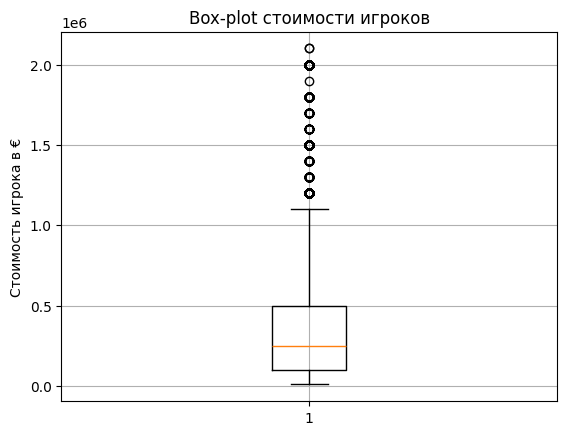

In [14]:
# Вычисляем первый (Q1) и третий (Q3) квартили данных
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
# Вычисляем межквартильный размах (IQR)
IQR = Q3 - Q1
# Отфильтровываем данные, удаляем аномалии
y_plot = y[~((y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR)))]

# Строим box-plot отфильтрованных данных
plt.boxplot(y_plot)
if log_target:
    plt.ylabel("Логарифмированная стоимость игрока в €")
else:
    plt.ylabel("Стоимость игрока в €")
plt.title("Box-plot стоимости игроков")
plt.grid(True)
plt.show()

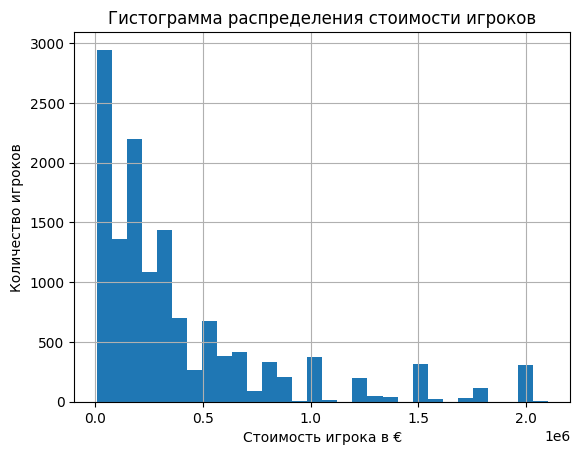

In [15]:
# Строим гистограмму распределения стоимости игроков
plt.hist(y_plot, bins=30)
if log_target:
    plt.xlabel("Логарифмированная стоимость игрока в €")
else:
    plt.xlabel("Стоимость игрока в €")
plt.ylabel("Количество игроков")
plt.title("Гистограмма распределения стоимости игроков")
plt.grid(True)
plt.show()

In [16]:
# Разбиваем данные на обучающий и тестовый датасеты
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [17]:
# Собираем все категориальные признаки из нашего датасета в список cat_features
cat_features = [col for col in X.columns if X[col].dtype == "object"]

In [33]:
# Создаем функцию для оптимизации параметров модели. Данная функция принимает на вход trial от Optuna и возвращает значение метрики (RMSE) на тестовой выборке.
def objective(trial: Trial):
    # Задаем пространство параметров для оптимизации
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 100),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100, log=True),
        "border_count": trial.suggest_int("border_count", 1, 10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    # Для некоторых типов бутстрепа subsample не используется
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1)
    
    # Создаем модель CatBoostRegressor с данными параметрами
    model = CatBoostRegressor(**params)
    model.fit(
        # Обучаем модель на тренировочных данных
        X_train,
        y_train,
        # Обозначаем датасет для проверки при обучении
        eval_set=[(X_test, y_test)],
        # Подавляем вывод информации о процессе обучения кэтбустом
        verbose=0,
        # Указываем количество ранних остановок
        early_stopping_rounds=100,
        # Указываем индексы категориальных признаков
        cat_features=cat_features,
    )

    # Предсказываем значения стоимости игроков на тестовых данных
    y_preds = model.predict(X_test)
    # Вычисляем значение метрики RMSE (корень из среднеквадратической ошибки)
    loss = loss_functions[loss_name](y_test, y_preds)

    return loss

In [34]:
# Создаем study и запускаем Optuna на минимизацию метрики
study = optuna.create_study(direction="minimize")
# Начинаем процесс оптимизации
study.optimize(objective, n_trials=100)

[I 2024-06-01 15:23:55,461] A new study created in memory with name: no-name-4db9d280-b73f-454d-ba5b-30987f59fa6b
[I 2024-06-01 15:23:59,992] Trial 0 finished with value: 1158768.471358907 and parameters: {'iterations': 546, 'depth': 10, 'learning_rate': 0.04867021526337393, 'random_strength': 6.37270545082459, 'od_wait': 22, 'l2_leaf_reg': 9.202861572504336e-05, 'border_count': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8060523105986293}. Best is trial 0 with value: 1158768.471358907.
[I 2024-06-01 15:24:00,416] Trial 1 finished with value: 1527672.070451012 and parameters: {'iterations': 194, 'depth': 7, 'learning_rate': 0.021792047434210003, 'random_strength': 52.225595022466685, 'od_wait': 25, 'l2_leaf_reg': 2.084907499724516e-08, 'border_count': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8785655479113509}. Best is trial 0 with value: 1158768.471358907.
[I 2024-06-01 15:24:01,655] Trial 2 finished with value: 1947414.55435199 and parameters: {'iterations': 952, 'depth':

### Наилучшие гиперпараметры обучения модели

In [20]:
# Итерируем по наилучшим параметрам, полученным с помощью оптимизации Optuna,
# и выводим их на экран
for key, value in study.best_params.items():
    print(f"{key}: {value}")

iterations: 977
depth: 9
learning_rate: 0.04057554952761181
random_strength: 1.9817817114147742
bagging_temperature: 49.80076319128576
od_wait: 32
l2_leaf_reg: 0.0013266926930993789
border_count: 8


### Обучение итоговой модели

In [21]:
# Инициализируем модель
model = CatBoostRegressor(**study.best_params)

# Обучаем модель
model.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 7779515.9220829	total: 7.83ms	remaining: 7.64s
1:	learn: 7554822.1083980	total: 14.7ms	remaining: 7.18s
2:	learn: 7355250.2590956	total: 23.1ms	remaining: 7.51s
3:	learn: 7178538.7924804	total: 31.5ms	remaining: 7.65s
4:	learn: 6987031.7949631	total: 38.9ms	remaining: 7.55s
5:	learn: 6814877.0610711	total: 47.7ms	remaining: 7.71s
6:	learn: 6647562.6897839	total: 56ms	remaining: 7.76s
7:	learn: 6479480.0098648	total: 63.8ms	remaining: 7.73s
8:	learn: 6307819.8140365	total: 71.5ms	remaining: 7.69s
9:	learn: 6144696.7101793	total: 80.4ms	remaining: 7.78s
10:	learn: 5991194.7663349	total: 88.4ms	remaining: 7.76s
11:	learn: 5863109.9207692	total: 95.3ms	remaining: 7.67s
12:	learn: 5715797.0388069	total: 102ms	remaining: 7.55s
13:	learn: 5559754.2204907	total: 110ms	remaining: 7.57s
14:	learn: 5429903.3623417	total: 118ms	remaining: 7.58s
15:	learn: 5304273.5039459	total: 126ms	remaining: 7.57s
16:	learn: 5182571.5335290	total: 134ms	remaining: 7.55s
17:	learn: 5059558.8848269	tota

### Оценка качества модели

In [22]:
# Получаем предсказания модели на тестовых данных
predictions = model.predict(X_test)

# Возвращаем таргет к нужному формату при необходимости
if log_target:
    predictions = np.expm1(predictions)
    y_test = np.expm1(y_test)
predictions = np.round(predictions)

In [23]:
example = pd.DataFrame()
# Построим отдельные столбцы для y_test и предсказаний
example["Факт"] = list(y_test[:5])
example["Прогноз"] = list(predictions[:5])
# Вычислим модуль разности ошибки
example["Модуль ошибки"] = abs(example["Факт"] - example["Прогноз"])
example.head()

,Факт,Прогноз,Модуль ошибки
0,300000,285520.0,14480.0
1,225000,142671.0,82329.0
2,650000,193682.0,456318.0
3,100000,278076.0,178076.0
4,500000,2429313.0,1929313.0


In [24]:
# Вычисляем среднеквадратическую ошибку (MSE)
mse = mean_squared_error(y_test, predictions)
# Извлекаем квадратный корень из MSE, чтобы получить RMSE
print("RMSE:", mse**0.5)

# Вычисляем среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

# Вычисляем коэффициент детерминации (R^2)
r2 = r2_score(y_test, predictions)
print("R^2:", r2)

# Вычисляем медианную абсолютную ошибку
medae = median_absolute_error(y_test, predictions)
print("Median Absolute Error:", medae)

# Вычисляем explained variance score
evs = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", evs)

# Вычисляем среднюю абсолютную процентную ошибку (MAPE)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error:", mape)

RMSE: 3256583.2694386216
MAE: 988967.1737918216
R^2: 0.8231011790127762
Median Absolute Error: 149350.5
Explained Variance Score: 0.8231043449772181
Mean Absolute Percentage Error: 1.0629049819284428


### Обучение модели на всех имеющихся данных

In [25]:
model.fit(X, y, cat_features=cat_features)

0:	learn: 7765358.3294111	total: 6.54ms	remaining: 6.38s
1:	learn: 7565458.4877478	total: 14ms	remaining: 6.82s
2:	learn: 7350662.4560938	total: 22.6ms	remaining: 7.32s
3:	learn: 7151502.8328500	total: 31.3ms	remaining: 7.62s
4:	learn: 6958489.5159257	total: 41.4ms	remaining: 8.04s
5:	learn: 6772454.3562328	total: 49.3ms	remaining: 7.98s
6:	learn: 6597452.3437578	total: 57.8ms	remaining: 8.02s
7:	learn: 6435750.1697119	total: 66.3ms	remaining: 8.02s
8:	learn: 6265740.8321047	total: 74.1ms	remaining: 7.97s
9:	learn: 6121672.9092169	total: 83ms	remaining: 8.03s
10:	learn: 5968789.8066622	total: 90.2ms	remaining: 7.92s
11:	learn: 5819287.0460397	total: 97.7ms	remaining: 7.86s
12:	learn: 5672714.2846318	total: 106ms	remaining: 7.84s
13:	learn: 5530270.2987161	total: 114ms	remaining: 7.85s
14:	learn: 5394308.7445766	total: 123ms	remaining: 7.88s
15:	learn: 5263219.9232347	total: 131ms	remaining: 7.86s
16:	learn: 5146240.1708157	total: 140ms	remaining: 7.91s
17:	learn: 5025441.2934491	total:

### Сохранение модели

In [26]:
# Сохраняем обученную модель в файл "best_model.cbm" для последующего использования
model.save_model("best_model.cbm")